# Neumeric Character Recognition

## Neural Network Approach

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import Adam

import logging
logging.getLogger("tensorflow").setLevel(logging.ERROR)
tf.autograph.set_verbosity(0)

In [2]:
df_train = pd.read_csv("ncr/train.csv")
df_test = pd.read_csv("ncr/test.csv")

In [3]:
print(f"Shape of Traning Dataset is: {df_train.shape}")
print(f"Shape of Testing Dataset is: {df_test.shape}")

Shape of Traning Dataset is: (42000, 785)
Shape of Testing Dataset is: (28000, 784)


### Let's make the target label and other columns seperate from the dataset

In [4]:
X = df_train.drop("label", axis=1)
y = df_train.label

In [5]:
X.head(1)

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
y[0]

1

In [7]:
df_train.isna().values.any()

False

There are no null values

## Let's Vizualize the data first

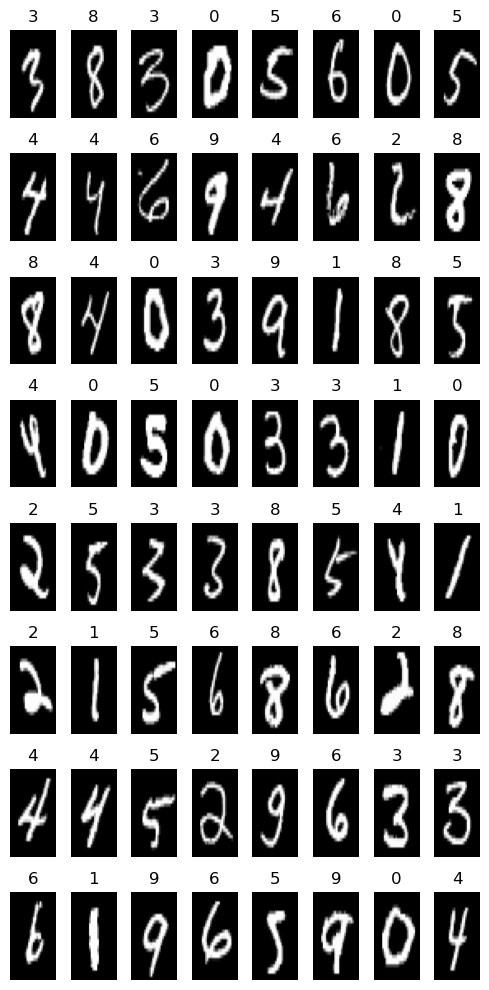

In [8]:
fig, axs = plt.subplots(8, 8, figsize=(5, 10))

axs = axs.flatten()
for ax in axs:
    rnd = np.random.randint(42000)
    rnd_img = X.loc[rnd].values.reshape(28, 28)

    ax.imshow(rnd_img, cmap="grey", aspect="auto")
    ax.set_title(str(y[rnd]))

    ax.set_axis_off()

plt.tight_layout()
plt.show()

## Now let's build the model

In [5]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234)

In [6]:
tf.random.set_seed(1234)

In [10]:
model = Sequential(
    [
        Dense(200, "relu", name="L1"),
        Dense(100, "relu", name="L2"),
        Dense(10, "linear", name="L3"),
    ]
)

In [11]:
model.compile(
    loss=SparseCategoricalCrossentropy(from_logits=True),
    optimizer=Adam(0.001)
)

In [13]:
model.fit(X_train, y_train, epochs=40)

Epoch 1/40
1050/1050 [==============================] - 3s 2ms/step - loss: 2.4552
Epoch 2/40
1050/1050 [==============================] - 2s 2ms/step - loss: 0.3374
Epoch 3/40
1050/1050 [==============================] - 2s 2ms/step - loss: 0.2266
Epoch 4/40
1050/1050 [==============================] - 2s 2ms/step - loss: 0.1825
Epoch 5/40
1050/1050 [==============================] - 3s 3ms/step - loss: 0.1524
Epoch 6/40
1050/1050 [==============================] - 3s 3ms/step - loss: 0.1518
Epoch 7/40
1050/1050 [==============================] - 3s 3ms/step - loss: 0.1198
Epoch 8/40
1050/1050 [==============================] - 3s 3ms/step - loss: 0.1266
Epoch 9/40
1050/1050 [==============================] - 3s 3ms/step - loss: 0.1268
Epoch 10/40
1050/1050 [==============================] - 3s 3ms/step - loss: 0.0938
Epoch 11/40
1050/1050 [==============================] - 3s 3ms/step - loss: 0.1061
Epoch 12/40
1050/1050 [==============================] - 3s 3ms/step - loss: 0.0884
E

In [14]:
pred = np.argmax(model.predict(X_test), axis=1)

263/263 [==============================] - 1s 2ms/step


In [15]:
pred.shape

(8400,)

In [7]:
from sklearn.metrics import accuracy_score

In [17]:
accuracy_score(pred, y_test)

0.9658333333333333

In [18]:
pred.shape

(8400,)

In [13]:
new_x = X_test.reset_index().drop("index", axis=1)
new_y = y_test.reset_index().drop("index", axis=1)

In [13]:
new_y.head()

,label
0,8
1,3
2,1
3,5
4,0


## Let's Vizualize the predicted Data

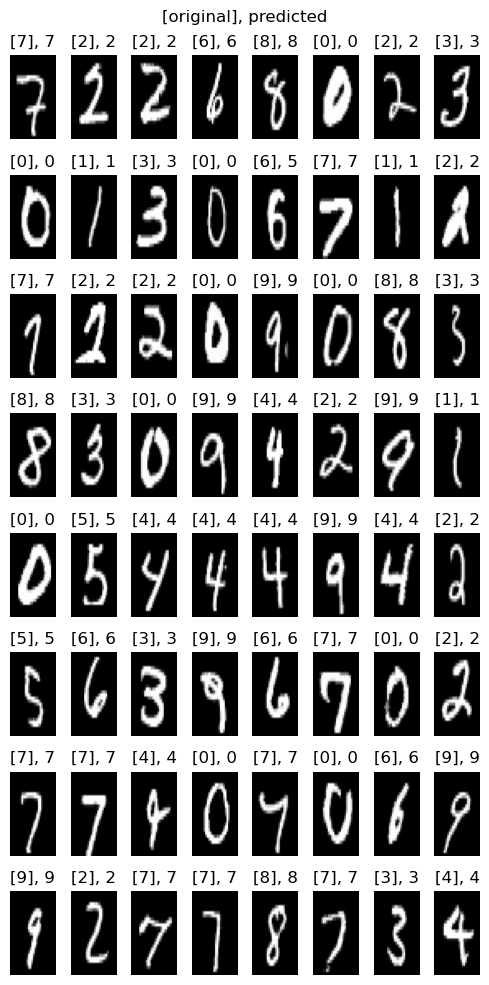

In [21]:
fig, axs = plt.subplots(8, 8, figsize=(5, 10))

axs = axs.flatten()
for ax in axs:
    rnd = np.random.randint(X_test.shape[0])
    rnd_img = new_x.loc[rnd].values.reshape(28, 28)

    ax.imshow(rnd_img, cmap="grey", aspect="auto")
    ax.set_title(f"{new_y.values[rnd]}, {pred[rnd]}")

    ax.set_axis_off()
    fig.suptitle("[original], predicted")

plt.tight_layout()
plt.show()

## Now lets predict the labels for the submission file

In [22]:
predictions = np.argmax(model.predict(df_test), axis=1)

875/875 [==============================] - 1s 2ms/step


In [23]:
sub = pd.DataFrame(predictions, columns=["Label"])

In [24]:
sub.index = sub.index + 1

In [25]:
sub.index.name = "ImageId"

In [26]:
sub.head()

,Label
ImageId,
1,2
2,0
3,9
4,9
5,3


In [27]:
sub.to_csv("submission.csv")

## XGBoost Approach

In [8]:
import xgboost as xgb

In [15]:
dtrain = xgb.DMatrix(X_train, y_train)
dtest = xgb.DMatrix(X_test, y_test)

In [20]:
param = {
    "booster": "gbtree",
    "objective": "multi:softmax",
    "smaple_type": "uniform",
    "normalize_type": "tree",
    "tree_method": "hist",
    "num_class": 10,
    "rate_drop": 0.1,
    "skip_drop": 0.5,
    "monotone_constraints": (-1, 1),
}

num_rounds = 100
bst = xgb.train(param, dtrain, num_rounds, evals=[(dtrain, "train"), (dtest, "valid")], early_stopping_rounds=10, verbose_eval=5)

C:\Users\abhis\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [14:02:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "normalize_type", "rate_drop", "skip_drop", "smaple_type" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	train-mlogloss:1.34646	valid-mlogloss:1.38483
[5]	train-mlogloss:0.43356	valid-mlogloss:0.51165
[10]	train-mlogloss:0.19815	valid-mlogloss:0.28890
[15]	train-mlogloss:0.10698	valid-mlogloss:0.20284
[20]	train-mlogloss:0.06564	valid-mlogloss:0.16400
[25]	train-mlogloss:0.04187	valid-mlogloss:0.14358
[30]	train-mlogloss:0.02818	valid-mlogloss:0.12962
[35]	train-mlogloss:0.01912	valid-mlogloss:0.12004
[40]	train-mlogloss:0.01328	valid-mlogloss:0.11291
[45]	train-mlogloss:0.00969	valid-mlogloss:0.10809
[50]	train-mlogloss:0.00730	valid-mlogloss:0.10459
[55]	train-mlogloss:0.00560	valid-mlogloss:0.10136
[60]	train-mlogloss:0.00446	valid-mlogloss:0.09939
[65]	train-mlogloss:0.00363	valid-mlogloss:0.09760
[70]	train-mlogloss:0.00299	valid-mlogloss:0.09568
[75]	train-mlogloss:0.00257	valid-mlogloss:0.09530
[80]	train-mlogloss:0.00222	valid-mlogloss:0.09472
[85]	train-mlogloss:0.00195	valid-mlogloss:0.09412
[90]	train-mlogloss:0.00174	valid-mlogloss:0.09402
[95]	train-mlogloss:0.00156	valid

In [21]:
pred = bst.predict(dtest)

In [22]:
accuracy_score(pred, y_test)

0.9704761904761905

In [45]:
test = xgb.DMatrix(df_test)

In [47]:
sub = pd.DataFrame(pred, columns=["Label"])
sub.index = sub.index + 1
sub.index.name = "ImageId"

In [44]:
sub.head()

,Label
ImageId,
1,2
2,0
3,9
4,9
5,3


In [48]:
sub.to_csv("submission2.csv")

In [16]:
# %pip install hyperopt
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe

# Bayesian Optimization with HYPEROPT

In [20]:
space={'max_depth': hp.quniform("max_depth", 3, 18, 1),
        'gamma': hp.uniform ('gamma', 1,9),
        'reg_alpha' : hp.quniform('reg_alpha', 40,180,1),
        'reg_lambda' : hp.uniform('reg_lambda', 0,1),
        'colsample_bytree' : hp.uniform('colsample_bytree', 0.5,1),
        'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1),
        'n_estimators': 40,
        'seed': 0
    }

In [29]:
def objective(space):
    clf=xgb.XGBClassifier(
                    n_estimators =space['n_estimators'], max_depth = int(space['max_depth']), gamma = space['gamma'],
                    reg_alpha = int(space['reg_alpha']),min_child_weight=int(space['min_child_weight']),
                    colsample_bytree=int(space['colsample_bytree']))
    
    evaluation = [( X_train, y_train), ( X_test, y_test)]
    
    clf.fit(X_train, y_train,
            eval_set=evaluation, eval_metric="auc",
            early_stopping_rounds=10,verbose=False)
    

    pred = clf.predict(X_test)
    print(pred)
    accuracy = accuracy_score(y_test, pred)
    print ("SCORE:", accuracy)
    return {'loss': -accuracy, 'status': STATUS_OK }

In [30]:
trials = Trials()

best_hyperparams = fmin(fn = objective,
                        space = space,
                        algo = tpe.suggest,
                        max_evals = 100,
                        trials = trials)

  0%|                                                                          | 0/100 [00:00<?, ?trial/s, best loss=?]

C:\Users\abhis\anaconda3\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\abhis\anaconda3\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



[3 3 1 ... 7 7 0]                                                                                                      
SCORE:                                                                                                                 
0.6035714285714285                                                                                                     
  1%|▍                                              | 1/100 [00:10<17:42, 10.73s/trial, best loss: -0.6035714285714285]

C:\Users\abhis\anaconda3\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\abhis\anaconda3\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



[3 3 1 ... 7 7 0]                                                                                                      
SCORE:                                                                                                                 
0.6225                                                                                                                 
  2%|█▏                                                         | 2/100 [00:21<17:44, 10.86s/trial, best loss: -0.6225]

C:\Users\abhis\anaconda3\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\abhis\anaconda3\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



[3 3 1 ... 7 7 0]                                                                                                      
SCORE:                                                                                                                 
0.6096428571428572                                                                                                     
  3%|█▊                                                         | 3/100 [00:32<17:09, 10.61s/trial, best loss: -0.6225]

C:\Users\abhis\anaconda3\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\abhis\anaconda3\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



[3 3 1 ... 7 7 0]                                                                                                      
SCORE:                                                                                                                 
0.6076190476190476                                                                                                     
  4%|██▎                                                        | 4/100 [00:42<16:53, 10.56s/trial, best loss: -0.6225]

C:\Users\abhis\anaconda3\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\abhis\anaconda3\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



[3 3 1 ... 7 7 0]                                                                                                      
SCORE:                                                                                                                 
0.6166666666666667                                                                                                     
  5%|██▉                                                        | 5/100 [00:53<16:43, 10.57s/trial, best loss: -0.6225]

C:\Users\abhis\anaconda3\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\abhis\anaconda3\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



[3 3 1 ... 7 7 0]                                                                                                      
SCORE:                                                                                                                 
0.6063095238095239                                                                                                     
  6%|███▌                                                       | 6/100 [01:03<16:29, 10.53s/trial, best loss: -0.6225]

C:\Users\abhis\anaconda3\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\abhis\anaconda3\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



[3 3 1 ... 7 7 0]                                                                                                      
SCORE:                                                                                                                 
0.6126190476190476                                                                                                     
  7%|████▏                                                      | 7/100 [01:14<16:18, 10.52s/trial, best loss: -0.6225]

C:\Users\abhis\anaconda3\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\abhis\anaconda3\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



[3 3 1 ... 7 7 0]                                                                                                      
SCORE:                                                                                                                 
0.606547619047619                                                                                                      
  8%|████▋                                                      | 8/100 [01:23<15:49, 10.32s/trial, best loss: -0.6225]

C:\Users\abhis\anaconda3\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\abhis\anaconda3\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



[3 3 1 ... 7 7 0]                                                                                                      
SCORE:                                                                                                                 
0.6225                                                                                                                 
  9%|█████▎                                                     | 9/100 [01:35<16:01, 10.57s/trial, best loss: -0.6225]

C:\Users\abhis\anaconda3\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\abhis\anaconda3\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



[3 3 1 ... 7 7 0]                                                                                                      
SCORE:                                                                                                                 
0.6245238095238095                                                                                                     
 10%|████▌                                         | 10/100 [01:45<15:57, 10.64s/trial, best loss: -0.6245238095238095]

C:\Users\abhis\anaconda3\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\abhis\anaconda3\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



[3 3 1 ... 7 7 0]                                                                                                      
SCORE:                                                                                                                 
0.6164285714285714                                                                                                     
 11%|█████                                         | 11/100 [01:56<15:55, 10.73s/trial, best loss: -0.6245238095238095]

C:\Users\abhis\anaconda3\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\abhis\anaconda3\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



[3 3 1 ... 7 7 0]                                                                                                      
SCORE:                                                                                                                 
0.6104761904761905                                                                                                     
 12%|█████▌                                        | 12/100 [02:07<15:39, 10.68s/trial, best loss: -0.6245238095238095]

C:\Users\abhis\anaconda3\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\abhis\anaconda3\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



[3 3 1 ... 7 7 0]                                                                                                      
SCORE:                                                                                                                 
0.6097619047619047                                                                                                     
 13%|█████▉                                        | 13/100 [02:17<15:22, 10.61s/trial, best loss: -0.6245238095238095]

C:\Users\abhis\anaconda3\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\abhis\anaconda3\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



[1 3 1 ... 7 7 0]                                                                                                      
SCORE:                                                                                                                 
0.6054761904761905                                                                                                     
 14%|██████▍                                       | 14/100 [02:28<15:06, 10.55s/trial, best loss: -0.6245238095238095]

C:\Users\abhis\anaconda3\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\abhis\anaconda3\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



[3 3 1 ... 7 7 0]                                                                                                      
SCORE:                                                                                                                 
0.6261904761904762                                                                                                     
 15%|██████▉                                       | 15/100 [02:38<14:48, 10.45s/trial, best loss: -0.6261904761904762]

C:\Users\abhis\anaconda3\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\abhis\anaconda3\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



[3 3 1 ... 7 7 0]                                                                                                      
SCORE:                                                                                                                 
0.6232142857142857                                                                                                     
 16%|███████▎                                      | 16/100 [02:49<14:42, 10.50s/trial, best loss: -0.6261904761904762]

C:\Users\abhis\anaconda3\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\abhis\anaconda3\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



[3 3 1 ... 7 7 0]                                                                                                      
SCORE:                                                                                                                 
0.6259523809523809                                                                                                     
 17%|███████▊                                      | 17/100 [03:00<14:53, 10.76s/trial, best loss: -0.6261904761904762]

C:\Users\abhis\anaconda3\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\abhis\anaconda3\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



[3 3 1 ... 7 7 0]                                                                                                      
SCORE:                                                                                                                 
0.608452380952381                                                                                                      
 18%|████████▎                                     | 18/100 [03:10<14:28, 10.59s/trial, best loss: -0.6261904761904762]

C:\Users\abhis\anaconda3\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\abhis\anaconda3\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



[3 3 1 ... 7 7 0]                                                                                                      
SCORE:                                                                                                                 
0.5988095238095238                                                                                                     
 19%|████████▋                                     | 19/100 [03:20<13:56, 10.33s/trial, best loss: -0.6261904761904762]

C:\Users\abhis\anaconda3\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\abhis\anaconda3\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



[3 3 1 ... 7 7 0]                                                                                                      
SCORE:                                                                                                                 
0.6177380952380952                                                                                                     
 20%|█████████▏                                    | 20/100 [03:31<14:02, 10.53s/trial, best loss: -0.6261904761904762]

C:\Users\abhis\anaconda3\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\abhis\anaconda3\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



[3 3 1 ... 7 7 0]                                                                                                      
SCORE:                                                                                                                 
0.615                                                                                                                  
 21%|█████████▋                                    | 21/100 [03:42<14:11, 10.78s/trial, best loss: -0.6261904761904762]

C:\Users\abhis\anaconda3\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\abhis\anaconda3\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



[3 3 1 ... 7 7 0]                                                                                                      
SCORE:                                                                                                                 
0.6258333333333334                                                                                                     
 22%|██████████                                    | 22/100 [03:54<14:32, 11.19s/trial, best loss: -0.6261904761904762]

C:\Users\abhis\anaconda3\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\abhis\anaconda3\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



[3 3 1 ... 7 7 0]                                                                                                      
SCORE:                                                                                                                 
0.6133333333333333                                                                                                     
 23%|██████████▌                                   | 23/100 [04:05<14:18, 11.15s/trial, best loss: -0.6261904761904762]

C:\Users\abhis\anaconda3\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\abhis\anaconda3\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



[3 3 1 ... 7 7 0]                                                                                                      
SCORE:                                                                                                                 
0.628095238095238                                                                                                      
 24%|███████████▎                                   | 24/100 [04:18<14:30, 11.45s/trial, best loss: -0.628095238095238]

C:\Users\abhis\anaconda3\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\abhis\anaconda3\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



[3 3 1 ... 7 7 0]                                                                                                      
SCORE:                                                                                                                 
0.6153571428571428                                                                                                     
 25%|███████████▊                                   | 25/100 [04:29<14:12, 11.37s/trial, best loss: -0.628095238095238]

C:\Users\abhis\anaconda3\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\abhis\anaconda3\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



[3 3 1 ... 7 7 0]                                                                                                      
SCORE:                                                                                                                 
0.6266666666666667                                                                                                     
 26%|████████████▏                                  | 26/100 [04:40<13:54, 11.28s/trial, best loss: -0.628095238095238]

C:\Users\abhis\anaconda3\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\abhis\anaconda3\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



[3 3 1 ... 7 7 0]                                                                                                      
SCORE:                                                                                                                 
0.6185714285714285                                                                                                     
 27%|████████████▋                                  | 27/100 [04:50<13:26, 11.05s/trial, best loss: -0.628095238095238]

C:\Users\abhis\anaconda3\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\abhis\anaconda3\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



[3 3 1 ... 7 7 0]                                                                                                      
SCORE:                                                                                                                 
0.6111904761904762                                                                                                     
 28%|█████████████▏                                 | 28/100 [05:00<12:53, 10.75s/trial, best loss: -0.628095238095238]

C:\Users\abhis\anaconda3\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\abhis\anaconda3\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



[3 3 1 ... 7 7 0]                                                                                                      
SCORE:                                                                                                                 
0.6091666666666666                                                                                                     
 29%|█████████████▋                                 | 29/100 [05:11<12:39, 10.70s/trial, best loss: -0.628095238095238]

C:\Users\abhis\anaconda3\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\abhis\anaconda3\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



[3 3 1 ... 7 7 0]                                                                                                      
SCORE:                                                                                                                 
0.6007142857142858                                                                                                     
 30%|██████████████                                 | 30/100 [05:21<12:13, 10.48s/trial, best loss: -0.628095238095238]

C:\Users\abhis\anaconda3\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\abhis\anaconda3\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



[3 3 1 ... 7 7 0]                                                                                                      
SCORE:                                                                                                                 
0.6272619047619048                                                                                                     
 31%|██████████████▌                                | 31/100 [05:32<12:22, 10.76s/trial, best loss: -0.628095238095238]

C:\Users\abhis\anaconda3\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\abhis\anaconda3\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



[3 3 1 ... 7 7 0]                                                                                                      
SCORE:                                                                                                                 
0.6242857142857143                                                                                                     
 32%|███████████████                                | 32/100 [05:43<12:10, 10.74s/trial, best loss: -0.628095238095238]

C:\Users\abhis\anaconda3\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\abhis\anaconda3\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



[3 3 1 ... 7 7 0]                                                                                                      
SCORE:                                                                                                                 
0.6153571428571428                                                                                                     
 33%|███████████████▌                               | 33/100 [05:53<11:51, 10.62s/trial, best loss: -0.628095238095238]

C:\Users\abhis\anaconda3\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\abhis\anaconda3\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



[3 3 1 ... 7 7 0]                                                                                                      
SCORE:                                                                                                                 
0.6126190476190476                                                                                                     
 34%|███████████████▉                               | 34/100 [06:07<12:33, 11.42s/trial, best loss: -0.628095238095238]

C:\Users\abhis\anaconda3\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\abhis\anaconda3\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



[1 3 1 ... 7 7 0]                                                                                                      
SCORE:                                                                                                                 
0.6044047619047619                                                                                                     
 35%|████████████████▍                              | 35/100 [06:18<12:19, 11.37s/trial, best loss: -0.628095238095238]

C:\Users\abhis\anaconda3\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\abhis\anaconda3\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



[3 3 1 ... 7 7 0]                                                                                                      
SCORE:                                                                                                                 
0.621547619047619                                                                                                      
 36%|████████████████▉                              | 36/100 [06:30<12:26, 11.67s/trial, best loss: -0.628095238095238]

C:\Users\abhis\anaconda3\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\abhis\anaconda3\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



[3 3 1 ... 7 7 0]                                                                                                      
SCORE:                                                                                                                 
0.6077380952380952                                                                                                     
 37%|█████████████████▍                             | 37/100 [06:42<12:20, 11.75s/trial, best loss: -0.628095238095238]

C:\Users\abhis\anaconda3\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\abhis\anaconda3\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



[3 3 1 ... 7 7 0]                                                                                                      
SCORE:                                                                                                                 
0.6152380952380953                                                                                                     
 38%|█████████████████▊                             | 38/100 [06:54<12:15, 11.86s/trial, best loss: -0.628095238095238]

C:\Users\abhis\anaconda3\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\abhis\anaconda3\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



[3 3 1 ... 7 7 0]                                                                                                      
SCORE:                                                                                                                 
0.6079761904761904                                                                                                     
 39%|██████████████████▎                            | 39/100 [07:06<12:00, 11.82s/trial, best loss: -0.628095238095238]

C:\Users\abhis\anaconda3\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\abhis\anaconda3\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



[3 3 1 ... 7 7 0]                                                                                                      
SCORE:                                                                                                                 
0.6227380952380952                                                                                                     
 40%|██████████████████▊                            | 40/100 [07:17<11:37, 11.63s/trial, best loss: -0.628095238095238]

C:\Users\abhis\anaconda3\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\abhis\anaconda3\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



[3 3 1 ... 7 7 0]                                                                                                      
SCORE:                                                                                                                 
0.6175                                                                                                                 
 41%|███████████████████▎                           | 41/100 [07:28<11:10, 11.37s/trial, best loss: -0.628095238095238]

C:\Users\abhis\anaconda3\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\abhis\anaconda3\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



[3 3 1 ... 7 7 0]                                                                                                      
SCORE:                                                                                                                 
0.6209523809523809                                                                                                     
 42%|███████████████████▋                           | 42/100 [07:38<10:40, 11.05s/trial, best loss: -0.628095238095238]

C:\Users\abhis\anaconda3\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\abhis\anaconda3\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



[3 3 1 ... 7 7 0]                                                                                                      
SCORE:                                                                                                                 
0.6061904761904762                                                                                                     
 43%|████████████████████▏                          | 43/100 [07:49<10:29, 11.04s/trial, best loss: -0.628095238095238]

C:\Users\abhis\anaconda3\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\abhis\anaconda3\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



[3 3 1 ... 7 7 0]                                                                                                      
SCORE:                                                                                                                 
0.6135714285714285                                                                                                     
 44%|████████████████████▋                          | 44/100 [08:00<10:13, 10.96s/trial, best loss: -0.628095238095238]

C:\Users\abhis\anaconda3\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\abhis\anaconda3\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



[3 3 1 ... 7 7 0]                                                                                                      
SCORE:                                                                                                                 
0.6242857142857143                                                                                                     
 45%|█████████████████████▏                         | 45/100 [08:11<09:59, 10.90s/trial, best loss: -0.628095238095238]

C:\Users\abhis\anaconda3\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\abhis\anaconda3\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



[3 3 1 ... 7 7 0]                                                                                                      
SCORE:                                                                                                                 
0.6089285714285714                                                                                                     
 46%|█████████████████████▌                         | 46/100 [08:21<09:39, 10.73s/trial, best loss: -0.628095238095238]

C:\Users\abhis\anaconda3\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\abhis\anaconda3\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



[3 3 1 ... 7 7 0]                                                                                                      
SCORE:                                                                                                                 
0.6167857142857143                                                                                                     
 47%|██████████████████████                         | 47/100 [08:32<09:29, 10.74s/trial, best loss: -0.628095238095238]

C:\Users\abhis\anaconda3\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\abhis\anaconda3\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



[3 3 1 ... 7 7 0]                                                                                                      
SCORE:                                                                                                                 
0.5997619047619047                                                                                                     
 48%|██████████████████████▌                        | 48/100 [08:44<09:35, 11.06s/trial, best loss: -0.628095238095238]

C:\Users\abhis\anaconda3\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\abhis\anaconda3\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



[3 3 1 ... 7 7 0]                                                                                                      
SCORE:                                                                                                                 
0.6258333333333334                                                                                                     
 49%|███████████████████████                        | 49/100 [08:55<09:33, 11.24s/trial, best loss: -0.628095238095238]

C:\Users\abhis\anaconda3\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\abhis\anaconda3\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



[3 3 1 ... 7 7 0]                                                                                                      
SCORE:                                                                                                                 
0.6142857142857143                                                                                                     
 50%|███████████████████████▌                       | 50/100 [09:06<09:13, 11.06s/trial, best loss: -0.628095238095238]

C:\Users\abhis\anaconda3\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\abhis\anaconda3\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



[3 3 1 ... 7 7 0]                                                                                                      
SCORE:                                                                                                                 
0.6242857142857143                                                                                                     
 51%|███████████████████████▉                       | 51/100 [09:17<09:01, 11.05s/trial, best loss: -0.628095238095238]

C:\Users\abhis\anaconda3\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\abhis\anaconda3\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



[3 3 1 ... 7 7 0]                                                                                                      
SCORE:                                                                                                                 
0.6101190476190477                                                                                                     
 52%|████████████████████████▍                      | 52/100 [09:29<08:59, 11.23s/trial, best loss: -0.628095238095238]

C:\Users\abhis\anaconda3\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\abhis\anaconda3\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



[3 3 1 ... 7 7 0]                                                                                                      
SCORE:                                                                                                                 
0.6092857142857143                                                                                                     
 53%|████████████████████████▉                      | 53/100 [09:40<08:43, 11.14s/trial, best loss: -0.628095238095238]

C:\Users\abhis\anaconda3\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\abhis\anaconda3\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



[3 3 1 ... 7 7 0]                                                                                                      
SCORE:                                                                                                                 
0.6180952380952381                                                                                                     
 54%|█████████████████████████▍                     | 54/100 [09:50<08:26, 11.02s/trial, best loss: -0.628095238095238]

C:\Users\abhis\anaconda3\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\abhis\anaconda3\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



[3 3 1 ... 7 7 0]                                                                                                      
SCORE:                                                                                                                 
0.6060714285714286                                                                                                     
 55%|█████████████████████████▊                     | 55/100 [10:02<08:19, 11.10s/trial, best loss: -0.628095238095238]

C:\Users\abhis\anaconda3\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\abhis\anaconda3\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



[3 3 1 ... 7 7 0]                                                                                                      
SCORE:                                                                                                                 
0.6259523809523809                                                                                                     
 56%|██████████████████████████▎                    | 56/100 [10:15<08:34, 11.70s/trial, best loss: -0.628095238095238]

C:\Users\abhis\anaconda3\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\abhis\anaconda3\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



[3 3 1 ... 7 7 0]                                                                                                      
SCORE:                                                                                                                 
0.6272619047619048                                                                                                     
 57%|██████████████████████████▊                    | 57/100 [10:27<08:25, 11.76s/trial, best loss: -0.628095238095238]

C:\Users\abhis\anaconda3\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\abhis\anaconda3\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



[3 3 1 ... 7 7 0]                                                                                                      
SCORE:                                                                                                                 
0.6125                                                                                                                 
 58%|███████████████████████████▎                   | 58/100 [10:38<08:06, 11.59s/trial, best loss: -0.628095238095238]

C:\Users\abhis\anaconda3\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\abhis\anaconda3\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



[3 3 1 ... 7 7 0]                                                                                                      
SCORE:                                                                                                                 
0.6226190476190476                                                                                                     
 59%|███████████████████████████▋                   | 59/100 [10:50<08:04, 11.82s/trial, best loss: -0.628095238095238]

C:\Users\abhis\anaconda3\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\abhis\anaconda3\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



[3 3 1 ... 7 7 0]                                                                                                      
SCORE:                                                                                                                 
0.6090476190476191                                                                                                     
 60%|████████████████████████████▏                  | 60/100 [11:01<07:37, 11.43s/trial, best loss: -0.628095238095238]

C:\Users\abhis\anaconda3\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\abhis\anaconda3\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



[3 3 1 ... 7 7 0]                                                                                                      
SCORE:                                                                                                                 
0.6160714285714286                                                                                                     
 61%|████████████████████████████▋                  | 61/100 [11:12<07:22, 11.34s/trial, best loss: -0.628095238095238]

C:\Users\abhis\anaconda3\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\abhis\anaconda3\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



[3 3 1 ... 7 7 0]                                                                                                      
SCORE:                                                                                                                 
0.6066666666666667                                                                                                     
 62%|█████████████████████████████▏                 | 62/100 [11:23<07:08, 11.27s/trial, best loss: -0.628095238095238]

C:\Users\abhis\anaconda3\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\abhis\anaconda3\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



[1 3 1 ... 7 7 0]                                                                                                      
SCORE:                                                                                                                 
0.6051190476190477                                                                                                     
 63%|█████████████████████████████▌                 | 63/100 [11:36<07:12, 11.69s/trial, best loss: -0.628095238095238]

C:\Users\abhis\anaconda3\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\abhis\anaconda3\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



[3 3 1 ... 7 7 0]                                                                                                      
SCORE:                                                                                                                 
0.6164285714285714                                                                                                     
 64%|██████████████████████████████                 | 64/100 [11:46<06:47, 11.31s/trial, best loss: -0.628095238095238]

C:\Users\abhis\anaconda3\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\abhis\anaconda3\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



[3 3 1 ... 7 7 0]                                                                                                      
SCORE:                                                                                                                 
0.6277380952380952                                                                                                     
 65%|██████████████████████████████▌                | 65/100 [11:57<06:33, 11.24s/trial, best loss: -0.628095238095238]

C:\Users\abhis\anaconda3\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\abhis\anaconda3\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



[3 3 1 ... 7 7 0]                                                                                                      
SCORE:                                                                                                                 
0.628095238095238                                                                                                      
 66%|███████████████████████████████                | 66/100 [12:08<06:22, 11.24s/trial, best loss: -0.628095238095238]

C:\Users\abhis\anaconda3\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\abhis\anaconda3\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



[3 3 1 ... 7 7 0]                                                                                                      
SCORE:                                                                                                                 
0.6261904761904762                                                                                                     
 67%|███████████████████████████████▍               | 67/100 [12:19<06:09, 11.19s/trial, best loss: -0.628095238095238]

C:\Users\abhis\anaconda3\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\abhis\anaconda3\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



[3 3 1 ... 7 7 0]                                                                                                      
SCORE:                                                                                                                 
0.6216666666666667                                                                                                     
 68%|███████████████████████████████▉               | 68/100 [12:30<05:56, 11.13s/trial, best loss: -0.628095238095238]

C:\Users\abhis\anaconda3\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\abhis\anaconda3\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



[3 3 1 ... 7 7 0]                                                                                                      
SCORE:                                                                                                                 
0.623452380952381                                                                                                      
 69%|████████████████████████████████▍              | 69/100 [12:42<05:46, 11.18s/trial, best loss: -0.628095238095238]

C:\Users\abhis\anaconda3\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\abhis\anaconda3\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



[3 3 1 ... 7 7 0]                                                                                                      
SCORE:                                                                                                                 
0.6264285714285714                                                                                                     
 70%|████████████████████████████████▉              | 70/100 [12:53<05:37, 11.23s/trial, best loss: -0.628095238095238]

C:\Users\abhis\anaconda3\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\abhis\anaconda3\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



[3 3 1 ... 7 7 0]                                                                                                      
SCORE:                                                                                                                 
0.6155952380952381                                                                                                     
 71%|█████████████████████████████████▎             | 71/100 [13:04<05:25, 11.21s/trial, best loss: -0.628095238095238]

C:\Users\abhis\anaconda3\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\abhis\anaconda3\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



[3 3 1 ... 7 7 0]                                                                                                      
SCORE:                                                                                                                 
0.6173809523809524                                                                                                     
 72%|█████████████████████████████████▊             | 72/100 [13:15<05:11, 11.14s/trial, best loss: -0.628095238095238]

C:\Users\abhis\anaconda3\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\abhis\anaconda3\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



[3 3 1 ... 7 7 0]                                                                                                      
SCORE:                                                                                                                 
0.6251190476190476                                                                                                     
 73%|██████████████████████████████████▎            | 73/100 [13:26<05:01, 11.18s/trial, best loss: -0.628095238095238]

C:\Users\abhis\anaconda3\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\abhis\anaconda3\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



[3 3 1 ... 7 7 0]                                                                                                      
SCORE:                                                                                                                 
0.6242857142857143                                                                                                     
 74%|██████████████████████████████████▊            | 74/100 [13:39<05:00, 11.54s/trial, best loss: -0.628095238095238]

C:\Users\abhis\anaconda3\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\abhis\anaconda3\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



[3 3 1 ... 7 7 0]                                                                                                      
SCORE:                                                                                                                 
0.6272619047619048                                                                                                     
 75%|███████████████████████████████████▎           | 75/100 [13:51<04:50, 11.60s/trial, best loss: -0.628095238095238]

C:\Users\abhis\anaconda3\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\abhis\anaconda3\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



[3 3 1 ... 7 7 0]                                                                                                      
SCORE:                                                                                                                 
0.6178571428571429                                                                                                     
 76%|███████████████████████████████████▋           | 76/100 [14:02<04:37, 11.55s/trial, best loss: -0.628095238095238]

C:\Users\abhis\anaconda3\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\abhis\anaconda3\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



[3 3 1 ... 7 7 0]                                                                                                      
SCORE:                                                                                                                 
0.6180952380952381                                                                                                     
 77%|████████████████████████████████████▏          | 77/100 [14:13<04:21, 11.36s/trial, best loss: -0.628095238095238]

C:\Users\abhis\anaconda3\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\abhis\anaconda3\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



[3 3 1 ... 7 7 0]                                                                                                      
SCORE:                                                                                                                 
0.6261904761904762                                                                                                     
 78%|████████████████████████████████████▋          | 78/100 [14:25<04:11, 11.43s/trial, best loss: -0.628095238095238]

C:\Users\abhis\anaconda3\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\abhis\anaconda3\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



[3 3 1 ... 7 7 0]                                                                                                      
SCORE:                                                                                                                 
0.6132142857142857                                                                                                     
 79%|█████████████████████████████████████▏         | 79/100 [14:36<03:58, 11.36s/trial, best loss: -0.628095238095238]

C:\Users\abhis\anaconda3\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\abhis\anaconda3\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



[3 3 1 ... 7 7 0]                                                                                                      
SCORE:                                                                                                                 
0.6148809523809524                                                                                                     
 80%|█████████████████████████████████████▌         | 80/100 [14:47<03:43, 11.20s/trial, best loss: -0.628095238095238]

C:\Users\abhis\anaconda3\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\abhis\anaconda3\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



[3 3 1 ... 7 7 0]                                                                                                      
SCORE:                                                                                                                 
0.6252380952380953                                                                                                     
 81%|██████████████████████████████████████         | 81/100 [14:58<03:32, 11.18s/trial, best loss: -0.628095238095238]

C:\Users\abhis\anaconda3\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\abhis\anaconda3\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



[3 3 1 ... 7 7 0]                                                                                                      
SCORE:                                                                                                                 
0.604047619047619                                                                                                      
 82%|██████████████████████████████████████▌        | 82/100 [15:09<03:21, 11.17s/trial, best loss: -0.628095238095238]

C:\Users\abhis\anaconda3\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\abhis\anaconda3\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



[3 3 1 ... 7 7 0]                                                                                                      
SCORE:                                                                                                                 
0.6092857142857143                                                                                                     
 83%|███████████████████████████████████████        | 83/100 [15:20<03:08, 11.09s/trial, best loss: -0.628095238095238]

C:\Users\abhis\anaconda3\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\abhis\anaconda3\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



[3 3 1 ... 7 7 0]                                                                                                      
SCORE:                                                                                                                 
0.6098809523809524                                                                                                     
 84%|███████████████████████████████████████▍       | 84/100 [15:32<03:04, 11.53s/trial, best loss: -0.628095238095238]

C:\Users\abhis\anaconda3\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\abhis\anaconda3\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



[3 3 1 ... 7 7 0]                                                                                                      
SCORE:                                                                                                                 
0.6261904761904762                                                                                                     
 85%|███████████████████████████████████████▉       | 85/100 [15:44<02:54, 11.63s/trial, best loss: -0.628095238095238]

C:\Users\abhis\anaconda3\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\abhis\anaconda3\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



[3 3 1 ... 7 7 0]                                                                                                      
SCORE:                                                                                                                 
0.6235714285714286                                                                                                     
 86%|████████████████████████████████████████▍      | 86/100 [15:56<02:43, 11.67s/trial, best loss: -0.628095238095238]

C:\Users\abhis\anaconda3\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\abhis\anaconda3\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



[3 3 1 ... 7 7 0]                                                                                                      
SCORE:                                                                                                                 
0.6104761904761905                                                                                                     
 87%|████████████████████████████████████████▉      | 87/100 [16:07<02:27, 11.37s/trial, best loss: -0.628095238095238]

C:\Users\abhis\anaconda3\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\abhis\anaconda3\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



[3 3 1 ... 7 7 0]                                                                                                      
SCORE:                                                                                                                 
0.6182142857142857                                                                                                     
 88%|█████████████████████████████████████████▎     | 88/100 [16:18<02:14, 11.24s/trial, best loss: -0.628095238095238]

C:\Users\abhis\anaconda3\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\abhis\anaconda3\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



[3 3 1 ... 7 7 0]                                                                                                      
SCORE:                                                                                                                 
0.625                                                                                                                  
 89%|█████████████████████████████████████████▊     | 89/100 [16:29<02:03, 11.20s/trial, best loss: -0.628095238095238]

C:\Users\abhis\anaconda3\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\abhis\anaconda3\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



[3 3 1 ... 7 7 0]                                                                                                      
SCORE:                                                                                                                 
0.6111904761904762                                                                                                     
 90%|██████████████████████████████████████████▎    | 90/100 [16:39<01:50, 11.04s/trial, best loss: -0.628095238095238]

C:\Users\abhis\anaconda3\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\abhis\anaconda3\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



[3 3 1 ... 7 7 0]                                                                                                      
SCORE:                                                                                                                 
0.6135714285714285                                                                                                     
 91%|██████████████████████████████████████████▊    | 91/100 [16:50<01:38, 10.96s/trial, best loss: -0.628095238095238]

C:\Users\abhis\anaconda3\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\abhis\anaconda3\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



[3 3 1 ... 7 7 0]                                                                                                      
SCORE:                                                                                                                 
0.6127380952380952                                                                                                     
 92%|███████████████████████████████████████████▏   | 92/100 [17:01<01:27, 10.94s/trial, best loss: -0.628095238095238]

C:\Users\abhis\anaconda3\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\abhis\anaconda3\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



[3 3 1 ... 7 7 0]                                                                                                      
SCORE:                                                                                                                 
0.626547619047619                                                                                                      
 93%|███████████████████████████████████████████▋   | 93/100 [17:12<01:17, 11.02s/trial, best loss: -0.628095238095238]

C:\Users\abhis\anaconda3\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\abhis\anaconda3\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



[3 3 1 ... 7 7 0]                                                                                                      
SCORE:                                                                                                                 
0.6147619047619047                                                                                                     
 94%|████████████████████████████████████████████▏  | 94/100 [17:23<01:05, 11.00s/trial, best loss: -0.628095238095238]

C:\Users\abhis\anaconda3\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\abhis\anaconda3\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



[3 3 1 ... 7 7 0]                                                                                                      
SCORE:                                                                                                                 
0.6183333333333333                                                                                                     
 95%|████████████████████████████████████████████▋  | 95/100 [17:36<00:57, 11.53s/trial, best loss: -0.628095238095238]

C:\Users\abhis\anaconda3\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\abhis\anaconda3\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



[3 3 1 ... 7 7 0]                                                                                                      
SCORE:                                                                                                                 
0.6083333333333333                                                                                                     
 96%|█████████████████████████████████████████████  | 96/100 [17:49<00:47, 11.90s/trial, best loss: -0.628095238095238]

C:\Users\abhis\anaconda3\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\abhis\anaconda3\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



[3 3 1 ... 7 7 0]                                                                                                      
SCORE:                                                                                                                 
0.6013095238095238                                                                                                     
 97%|█████████████████████████████████████████████▌ | 97/100 [18:00<00:35, 11.71s/trial, best loss: -0.628095238095238]

C:\Users\abhis\anaconda3\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\abhis\anaconda3\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



[3 3 1 ... 7 7 0]                                                                                                      
SCORE:                                                                                                                 
0.6070238095238095                                                                                                     
 98%|██████████████████████████████████████████████ | 98/100 [18:11<00:22, 11.43s/trial, best loss: -0.628095238095238]

C:\Users\abhis\anaconda3\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\abhis\anaconda3\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



[3 3 1 ... 7 7 0]                                                                                                      
SCORE:                                                                                                                 
0.6173809523809524                                                                                                     
 99%|██████████████████████████████████████████████▌| 99/100 [18:22<00:11, 11.32s/trial, best loss: -0.628095238095238]

C:\Users\abhis\anaconda3\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

C:\Users\abhis\anaconda3\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



[3 3 1 ... 7 7 0]                                                                                                      
SCORE:                                                                                                                 
0.6023809523809524                                                                                                     
100%|██████████████████████████████████████████████| 100/100 [18:33<00:00, 11.13s/trial, best loss: -0.628095238095238]


In [31]:
print("The best hyperparameters are : ","\n")
print(best_hyperparams)

The best hyperparameters are :  

{'colsample_bytree': 0.906800545623152, 'gamma': 1.091108516447685, 'max_depth': 6.0, 'min_child_weight': 6.0, 'reg_alpha': 40.0, 'reg_lambda': 0.8886134839328019}


In [35]:
clf=xgb.XGBClassifier(
                    n_estimators =40, max_depth = 6, gamma = 1.091108516447685,
                    reg_alpha = 40,min_child_weight=6,
                    colsample_bytree=0.906800545623152, reg_lambda=0.8886134839328019)

In [36]:
evaluation = [( X_train, y_train), ( X_test, y_test)]
clf.fit(X_train, y_train,
        eval_set=evaluation, eval_metric="auc",
        early_stopping_rounds=10,verbose=False)

C:\Users\abhis\anaconda3\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\abhis\anaconda3\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.906800545623152, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=1.091108516447685,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=6, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=40, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [37]:
pred = clf.predict(X_test)
print(pred)
accuracy = accuracy_score(y_test, pred)

[8 3 1 ... 7 7 2]


In [38]:
accuracy

0.9382142857142857

In [ ]:
space={'max_depth': hp.quniform("max_depth", 3, 18, 1),
        'gamma': hp.uniform ('gamma', 1,9),
        'reg_alpha' : hp.quniform('reg_alpha', 40,180,1),
        'reg_lambda' : hp.uniform('reg_lambda', 0,1),
        'colsample_bytree' : hp.uniform('colsample_bytree', 0.5,1),
        'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1),
        'n_estimators': 40,
        'seed': 0
    }

In [ ]:
param = {
    "booster": "dart",
    "objective": "multi:softmax",
    "smaple_type": "uniform",
    "normalize_type": "tree",
    "tree_method": "hist",
    "num_class": 10,
    "rate_drop": 0.1,
    "skip_drop": 0.5,
    "monotone_constraints": (-1, 1),
}

num_rounds = 100
bst = xgb.train(param, dtrain, num_rounds, evals=[(dtrain, "train"), (dtest, "valid")], early_stopping_rounds=10, verbose_eval=5)

In [50]:
space2 = {
    "booster": "gbtree",                                   # Can also use dart
    "objective": "multi:softmax",
    'max_depth': hp.quniform("max_depth", 3, 18, 1),
    "sample": "uniform",                                   # Can also use weighted
    "normalize_type": "tree",                              # Can also use forest
    'rate_drop': hp.uniform("rate_drop", 0, 1),
    'skip_drop': hp.uniform("skip_drop", 0, 1),
    # 'gamma': hp.uniform ('gamma', 1,9),
    'reg_alpha' : hp.quniform('reg_alpha', 40,180,1),
    'reg_lambda' : hp.uniform('reg_lambda', 0,1),
    # 'colsample_bytree' : hp.uniform('colsample_bytree', 0,1),
    'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1),
    # 'eta': hp.uniform("eta", 0, 1),
    "num_class": 10,
    "tree_method": "hist"
}

In [43]:
num_rounds = 5

In [44]:
def objective(space):
    clf=xgb.train(space2, dtrain, num_rounds, evals=[(dtrain, "train"), (dtest, "valid")], early_stopping_rounds=10, verbose_eval=4)

    pred = clf.predict(X_test)
    print(pred)
    accuracy = accuracy_score(y_test, pred)
    print ("SCORE:", accuracy)
    return {'loss': -accuracy, 'status': STATUS_OK }

In [51]:
trials = Trials()

best_hyperparams = fmin(fn = objective,
                        space = space2,
                        algo = tpe.suggest,
                        max_evals = 50,
                        trials = trials)

  0%|                                                                           | 0/50 [00:00<?, ?trial/s, best loss=?]

job exception: Invalid Parameter format for max_depth expect int but value='0 float
1   hyperopt_param
2     Literal{max_depth}
3     quniform
4       Literal{3}
5       Literal{18}
6       Literal{1}'



  0%|                                                                           | 0/50 [00:00<?, ?trial/s, best loss=?]


XGBoostError: Invalid Parameter format for max_depth expect int but value='0 float
1   hyperopt_param
2     Literal{max_depth}
3     quniform
4       Literal{3}
5       Literal{18}
6       Literal{1}'

In [9]:
from optuna.samplers import TPESampler
import optuna
from lightgbm import LGBMClassifier

C:\Users\abhis\anaconda3\Lib\site-packages\dask\dataframe\_pyarrow_compat.py:23: UserWarning: You are using pyarrow version 11.0.0 which is known to be insecure. See https://www.cve.org/CVERecord?id=CVE-2023-47248 for further details. Please upgrade to pyarrow>=14.0.1 or install pyarrow-hotfix to patch your current version.
  warnings.warn(


In [10]:
def objective(trial, X_train, y_train, X_test, y_test):
    # Define parameters to be optimized for the LGBMClassifier
    param = {
        "objective": "multiclass",
        "metric": "multi_logloss",
        "verbosity": -1,
        "boosting_type": "gbdt",
        "random_state": 42,
        "num_class": 7,
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.05),
        "n_estimators": trial.suggest_int("n_estimators", 400, 600),
        "lambda_l1": trial.suggest_float("lambda_l1", 0.005, 0.015),
        "lambda_l2": trial.suggest_float("lambda_l2", 0.02, 0.06),
        "max_depth": trial.suggest_int("max_depth", 6, 14),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.3, 0.9),
        "subsample": trial.suggest_float("subsample", 0.8, 1.0),
        "min_child_samples": trial.suggest_int("min_child_samples", 10, 50),
    }

    # Create an instance of LGBMClassifier with the suggested parameters
    lgbm_classifier = LGBMClassifier(**param)
    
    # Fit the classifier on the training data
    lgbm_classifier.fit(X_train, y_train)

    # Evaluate the classifier on the test data
    score = lgbm_classifier.score(X_test, y_test)

    return score

# Split the data into training and test sets
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)  # Adjust the test_size as needed

# Set up the sampler for Optuna optimization
sampler = optuna.samplers.TPESampler(seed=42)  # Using Tree-structured Parzen Estimator sampler for optimization

# Create a study object for Optuna optimization
study = optuna.create_study(direction="maximize", sampler=sampler)

# Run the optimization process
study.optimize(lambda trial: objective(trial, X_train, y_train, X_test, y_test), n_trials=100)

# Get the best parameters after optimization
best_params = study.best_params

print('='*50)
print(best_params)

[I 2024-02-17 22:30:41,247] A new study created in memory with name: no-name-a0b2321a-2340-432b-93ca-3d5ee9851d46
[I 2024-02-17 22:31:49,031] Trial 0 finished with value: 0.9747619047619047 and parameters: {'learning_rate': 0.0249816047538945, 'n_estimators': 591, 'lambda_l1': 0.012319939418114049, 'lambda_l2': 0.04394633936788146, 'max_depth': 7, 'colsample_bytree': 0.3935967122017216, 'subsample': 0.8116167224336399, 'min_child_samples': 45}. Best is trial 0 with value: 0.9747619047619047.
[I 2024-02-17 22:33:36,640] Trial 1 finished with value: 0.9773809523809524 and parameters: {'learning_rate': 0.034044600469728355, 'n_estimators': 542, 'lambda_l1': 0.005205844942958024, 'lambda_l2': 0.05879639408647977, 'max_depth': 13, 'colsample_bytree': 0.4274034664069657, 'subsample': 0.8363649934414201, 'min_child_samples': 17}. Best is trial 1 with value: 0.9773809523809524.
[W 2024-02-17 22:33:47,475] Trial 2 failed with parameters: {'learning_rate': 0.02216968971838151, 'n_estimators': 50

KeyboardInterrupt: 

In [12]:
med_params = {
    "objective": "multiclass",          # Objective function for the model
    "metric": "multi_logloss",          # Evaluation metric
    "verbosity": -1,                    # Verbosity level (-1 for silent)
    "boosting_type": "gbdt",            # Gradient boosting type
    "random_state": 42,       # Random state for reproducibility
    "num_class": 7,
    'learning_rate': 0.02216968971838151, 
    'n_estimators': 505, 
    'lambda_l1': 0.009319450186421156, 
    'lambda_l2': 0.03164916560792168, 
    'max_depth': 11, 
    'colsample_bytree': 0.3836963163912251, 
    'subsample': 0.8584289297070437, 
    'min_child_samples': 25
}

In [13]:
lgbm_classifier = LGBMClassifier(**med_params)
lgbm_classifier.fit(X_train, y_train)
y_pred = lgbm_classifier.predict(X_test)
accuracy_score(y_pred, y_test)

0.973452380952381